In [5]:
# Importing dependencies
from datetime import datetime
import numpy as np
import scipy.io
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import detrend, welch, windows
from obspy.signal.util import next_pow_2
import matplotlib.pyplot as plt

In [4]:
#!pip install obspy

# Example timestamp extraction and alignment 

First, you need to load the csv data files, containing inter-beat intervals (or R-R intervals). Heart rate is normally calculated based on R-R intervals, i.e., 60 seconds /RR_interval (in seconds) is your heart rate in beats per minute for each beat. 

In the file, you will find a start time, which indicates the time the device began recording. In the column "Artifact corrected RR", you will find the inter-beat intervals in milliseconds, which have been corrected for artifacts. 

In [ ]:
# Load file from csv file
start_info = list(pd.read_csv("your_csv_file.csv", skiprows=1, nrows=0, sep=";").columns)
data = pd.read_csv('your_csv_file.csv', delimiter=';', skiprows=3).drop(columns = 'Unnamed: 3')
RR = data['Artifact corrected RR']

#convert from miliseconds to seconds
RR_seconds = RR / 1000

# the last value should tell us how many seconds passed from the beginning to the end of the experiment
RR_cumsum = np.cumsum(RR_seconds.values)

In [45]:
# Function to convert timestamps to datetime python object
def convert_time_to_datetime(t):
    return datetime.strptime(t, '%H:%M:%S')

In [46]:
# Obtaining timestamps from bodyguard device
start_time = start_info[0].split(" ")[-1] # to only get the time without text and date.
st = convert_time_to_datetime(start_time)

# Enter the start time of your condition/task
time_cs = '14:20:55' # Start time goes here (e.g., for arithmetic 1)
time_ce = '14:24:55' # End time goes here (e.g., for arithmetic 1)
cs = convert_time_to_datetime(time_cs)
ce = convert_time_to_datetime(time_ce)

task_length = (ce - cs).seconds
time_task_start = (cs - st).seconds
time_task_end = (ce - st).seconds

In [47]:
# Obtaining indexes for the start and the end of a condition
start_idx = len(RR_cumsum[RR_cumsum < time_task_start]) 
end_idx = len(RR_cumsum[RR_cumsum < time_task_end]) 

#Selecting the task-relevant RR data
RR_data = np.array(RR_seconds[start_idx:end_idx]).reshape(-1)
print('The index of the beginning of your task/condition is: ' + str(start_idx))
print('The index of the end of your task/condition is: ' + str(end_idx))

#confirm that the length of the task/condition agrees with the time logged between indices
#print(np.allclose(np.sum(RR_seconds[start_idx:end_idx]), task_length, rtol=0.01))

The index of the beginning of your task/condition is: 840
The index of the end of your task/condition is: 1094


### Time index

Now create a time index for your RR intervals - i.e., the time at which each RR intervals occur, in relation to the beginning of each condition. 

Plot your RR intervals prior to interpolation, and inspect for outliers. Remember, your RR intervals are still not sampled in time. 

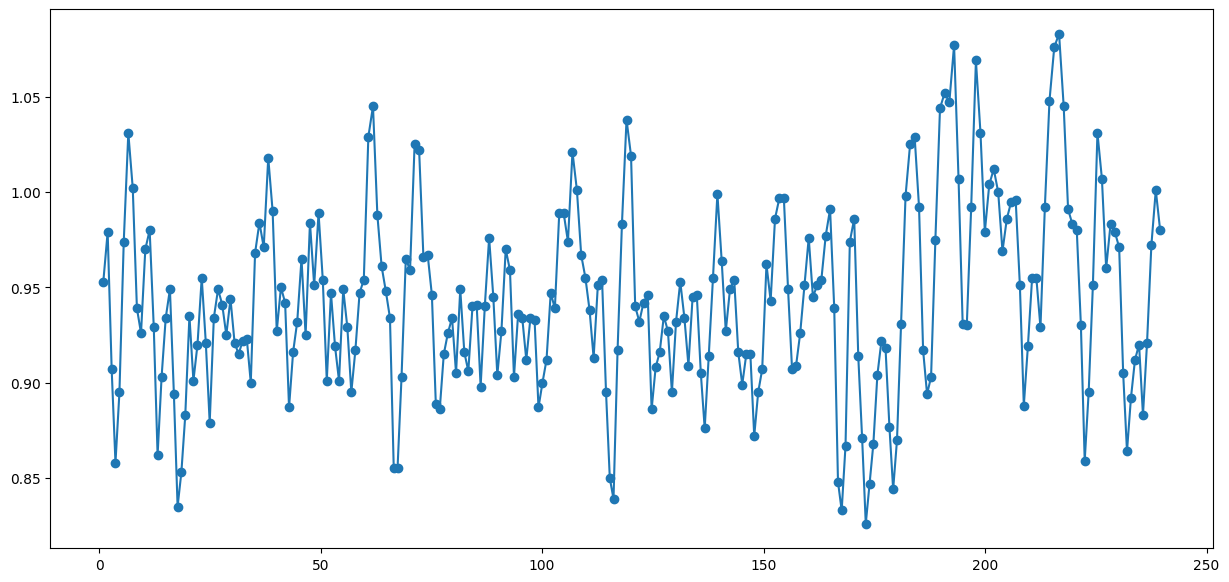

In [48]:
# Creating the time stamp
timestamp = np.cumsum(RR_data)
# Plotting R-R interval prior to interpolation
plt.figure(figsize = (15,7))
plt.plot(timestamp, RR_data, '-o')